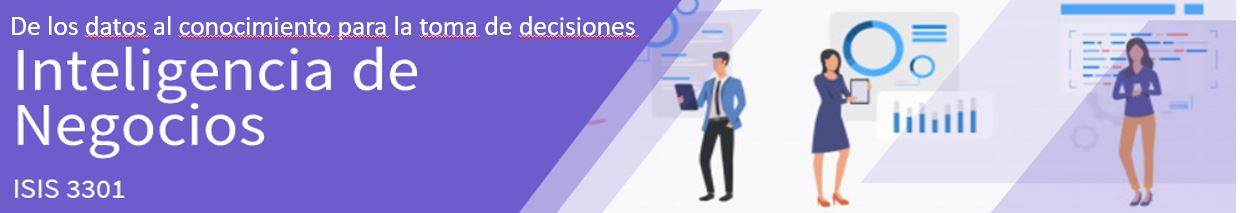

# LABORATORIO 4

## Carga de librerías necesarias para implementación

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Composicion de pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

# Regresion lineal
from sklearn.linear_model import LinearRegression

# Importar/ Exportar modelos
from joblib import dump, load


## Cargar y limpieza de los datos

In [2]:
# Se cargan los datos. 
df_original = pd.read_csv('202220_Laboratorio_3_data_university_admission_train.csv', on_bad_lines = 'skip')
df_tracks = df_original.copy()
print(df_tracks.shape)
df_tracks.head(5)


(1569, 10)


,Unnamed: 0,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admission Points
0,0,479,327,113,4,4.00,2.77,8.88,1,84.47
1,1,446,301,92,1,1.85,1.50,7.71,0,45.08
2,2,336,297,100,1,2.41,1.59,7.89,0,47.42
3,3,20,303,98,3,3.50,3.00,8.50,0,62.00
4,4,432,320,94,2,1.38,3.50,8.78,1,73.00


In [3]:
df_recent = pd.read_csv('202220_Laboratorio_3_data_university_admission_test.csv')

print(df_recent.shape)
df_recent.head(5)

(175, 8)


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,117,299,102,3,4.0,3.5,8.62,0
1,49,321,110,3,3.5,5.0,8.85,1
2,94,301,97,2,3.0,3.0,7.88,1
3,108,338,117,4,3.5,4.5,9.46,1
4,327,299,100,3,2.0,2.0,8.02,0


In [4]:
#Verificar si hay nulos
df_tracks.isnull().sum()

Unnamed: 0            0
Serial No.            0
GRE Score             0
TOEFL Score           0
University Rating     0
SOP                   0
LOR                   0
CGPA                  0
Research              0
Admission Points     65
dtype: int64

## Perfilamiento y Entendimiento de los Datos 

Ya todas las variables son numéricas.

In [5]:
# Eliminamos los registros que tienen la variable objetivo nula
df_tracks = df_tracks.dropna(subset = ['Admission Points'])

In [6]:
df_tracks.isnull().sum()

Unnamed: 0           0
Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Admission Points     0
dtype: int64

In [7]:
#Normalización de train
scaler = MinMaxScaler()
transformed_df= scaler.fit_transform(df_tracks)

transformed_df = pd.DataFrame(transformed_df)
transformed_df.columns = df_tracks.columns

In [8]:
print(transformed_df.dtypes) 

Unnamed: 0           float64
Serial No.           float64
GRE Score            float64
TOEFL Score          float64
University Rating    float64
SOP                  float64
LOR                  float64
CGPA                 float64
Research             float64
Admission Points     float64
dtype: object


## Creación de pipelines

In [9]:
# Preprocesamiento
# Se usa un transformador para seleccionar unicamente las columnas que se quieren usar
selected_cols = ['University Rating','GRE Score','TOEFL Score','CGPA']

# Error
# Se necesita incluir el esquema de nulos, ya que la regresion no sabe como lidear con ellos
# codigo con error:
pre = [('initial',ColumnTransformer([("selector", 'passthrough',selected_cols)])),]
pre = [('initial',ColumnTransformer([("selector", 'passthrough',selected_cols)])),
       ('imputer', SimpleImputer(missing_values=np.nan, strategy='median'))]

In [10]:
# Modelo
model = [('model', LinearRegression())]

In [11]:
# Decalra el pipeline
pipeline = Pipeline(pre+model)

In [12]:
# Extraemos las variables explicativas y objetivo para entrenar
X = transformed_df.drop('Admission Points', axis = 1)
y = transformed_df['Admission Points']

pipeline = pipeline.fit(X,y)

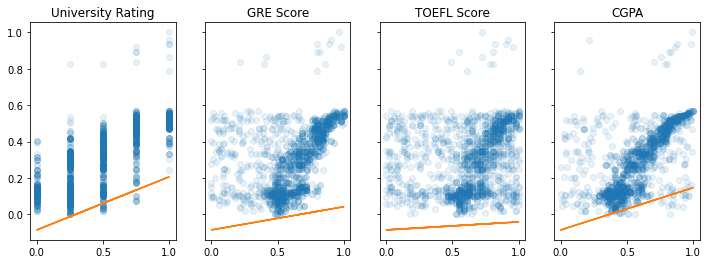

In [13]:
# Visualizamos la regresion lineal en cada dimension
f, axs = plt.subplots(1, len(selected_cols), sharey=True, figsize = (12,4))

for i in range(len(selected_cols)):

    pos_col = i
    col = selected_cols[pos_col]

    # Variable x
    x = X[col]
    # Pendiente
    m = pipeline['model'].coef_[pos_col]
    # Interceto
    b = pipeline['model'].intercept_

    axs[i].plot(x, y, 'o', alpha = 0.1)
    axs[i].plot(x, x*m + b)
    axs[i].set_title(col)


## 5. Exportar e Importar el Modelo 

In [14]:
# Usamos la lbreria joblib
filename = 'modelo.joblib'
# Se guarda
dump(pipeline, filename) 

['modelo.joblib']

In [15]:
# Se lee
p2 = load(filename)
p2

Pipeline(steps=[('initial',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['University Rating',
                                                   'GRE Score', 'TOEFL Score',
                                                   'CGPA'])])),
                ('imputer', SimpleImputer(strategy='median')),
                ('model', LinearRegression())])

In [16]:
# Clasificamos los datos recientes
df_recent['Admission Points'] = p2.predict(df_recent)

<AxesSubplot:xlabel='Admission Points', ylabel='Count'>

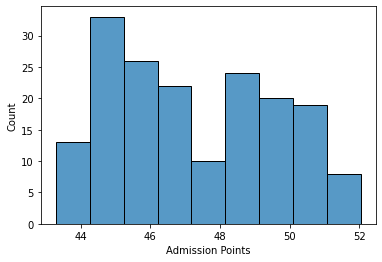

In [17]:
sns.histplot(df_recent['Admission Points'])

## 6. Coeficientes

Los coeficientes de la regresión nos pueden dar información sobre la relación entre las variables observadas y la variable objetivo.

In [18]:
pipeline['model'].coef_

array([0.29141814, 0.12736505, 0.04402555, 0.23193259])

In [19]:
# En DataFrame
pd.DataFrame({'columns':selected_cols, 'coef':pipeline['model'].coef_})

,columns,coef
0,University Rating,0.291418
1,GRE Score,0.127365
2,TOEFL Score,0.044026
3,CGPA,0.231933


In [20]:
pre = [('initial',ColumnTransformer([("selector", 'passthrough',selected_cols)])),
       ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
       ('scaler', MinMaxScaler())] # agrega el scaler

model = [('model', LinearRegression())]

pipeline = Pipeline(pre+model)

pipeline = pipeline.fit(X,y)

In [21]:
# Vuelve a imprimir los coeficientes
pd.DataFrame({'columns':selected_cols, 'coef':pipeline['model'].coef_})


,columns,coef
0,University Rating,0.291418
1,GRE Score,0.127365
2,TOEFL Score,0.044026
3,CGPA,0.231933
